In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
%matplotlib inline

In [23]:

#データセットを用意
#Mnistを用意
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [25]:
#モデルを作成
#エンコーダー
class Encoder(tf.keras.Model):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__() #親クラスのコンストラクタを呼び出す
    self.input_dim = input_dim      #入力次元
    self.hidden_dim = hidden_dim    #隠れ層の次元
    self.latent_dim = latent_dim    #潜在空間の次元
    
    #エンコーダーの構造を定義
    self.dense_1 = Dense(self.hidden_dim, activation='relu')
    self.dense_mu = Dense(self.latent_dim, activation='linear')
    self.dense_sigma = Dense(self.latent_dim, activation='linear')
  
  #エンコーダーの計算を定義
  def call(self, x_input):
      hidden = self.dense_1(x_input)        #隠れ層の計算 input -> hidden
      mu = self.dense_mu(hidden)            #平均の計算 hidden -> mu
      log_sigma = self.dense_sigma(hidden)  #分散の計算 hidden -> log_sigma
      
      eps = K.random_normal(shape=(self.latent_dim,), mean=0., stddev=0.1)  #noiseの計算
      z = mu + K.exp(log_sigma) * eps       #潜在変数の計算 mu, log_sigma -> z
       
      return mu, log_sigma, z

In [27]:
#デコーダー
class Decoder(tf.keras.Model):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Decoder, self).__init__() #親クラスのコンストラクタを呼び出す
    self.input_dim = input_dim      #入力次元
    self.hidden_dim = hidden_dim    #隠れ層の次元
    self.latent_dim = latent_dim    #潜在空間の次元
    
    #デコーダーの構造を定義
    self.dense_1 = Dense(self.hidden_dim, activation='relu')  # de
    self.dense_output = Dense(self.input_dim, activation='sigmoid')
 
  def call(self, z):
      hidden = self.dense_1(z)    #隠れ層の計算 z -> hidden
      output = self.dense_output(hidden)  #出力の計算 hidden -> output
      return output

In [29]:
#VAE
# VAEの構造を定義 encoder, decoder を結合
class VAE(tf.keras.Model):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__() #親クラスのコンストラクタを呼び出す
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)   #エンコーダー
    self.decoder = Decoder(input_dim, hidden_dim, latent_dim)   #デコーダー
   
   
   #VAEの計算を定義
  def call(self, x):
    mu, log_sigma, z = self.encode(x) #mu = 平均, log_sigma = 分散, z = 潜在変数
    x_decoded = self.decode(z) # x_decoded = 出力
    return mu, log_sigma, x_decoded, z  
 
  def encode(self, x):
    mu, log_sigma, z = self.encoder(x)
    return mu, log_sigma, z
 
  def decode(self, z):
    x_decoded = self.decoder(z)
    return x_decoded

In [31]:

#損失関数の定義
def loss_function(label, predict, mu, log_sigma): 
  reconstruction_loss = tf.keras.losses.binary_crossentropy(label, predict) #再構成誤差
  reconstruction_loss *= 768 
  kl_loss = 1 + log_sigma - K.square(mu) - K.exp(log_sigma) #KLダイバージェンス
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  return vae_loss

In [33]:
@tf.function #学習用の関数を定義
def train_step(x):
    loss = 0
    with tf.GradientTape() as tape:
        mu, log_sigma, x_reconstructed, z = vae(x, training=True)
        loss += loss_function(x, x_reconstructed, mu, log_sigma)
    batch_loss = (loss / len(x))
    variables = vae.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
     
    # accuracyの計算用
    return batch_loss

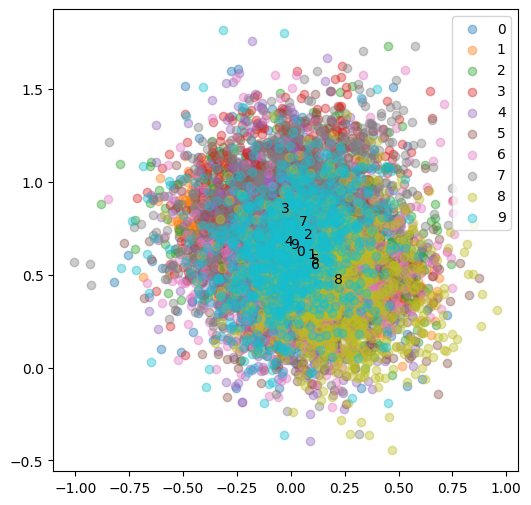

Epoch 1 Batch 233 Loss 0.7678
Epoch 2 Batch 233 Loss 0.7345
Epoch 3 Batch 233 Loss 0.7072
Epoch 4 Batch 233 Loss 0.7061
Epoch 5 Batch 233 Loss 0.6747
Epoch 6 Batch 233 Loss 0.6647
Epoch 7 Batch 233 Loss 0.6617
Epoch 8 Batch 233 Loss 0.6503
Epoch 9 Batch 233 Loss 0.6515
Epoch 10 Batch 233 Loss 0.6361
Epoch 11 Batch 233 Loss 0.6491
Epoch 12 Batch 233 Loss 0.6379
Epoch 13 Batch 233 Loss 0.6344
Epoch 14 Batch 233 Loss 0.6340
Epoch 15 Batch 233 Loss 0.6238
Epoch 16 Batch 233 Loss 0.6180
Epoch 17 Batch 233 Loss 0.5990
Epoch 18 Batch 233 Loss 0.6102
Epoch 19 Batch 233 Loss 0.6169
Epoch 20 Batch 233 Loss 0.5966


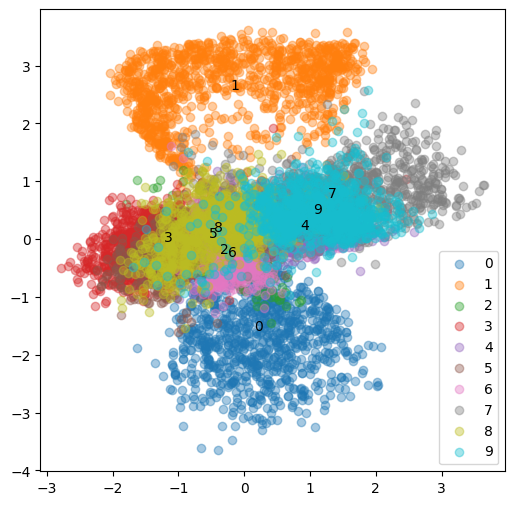

Epoch 21 Batch 233 Loss 0.6038
Epoch 22 Batch 233 Loss 0.6016
Epoch 23 Batch 233 Loss 0.6114
Epoch 24 Batch 233 Loss 0.6104
Epoch 25 Batch 233 Loss 0.5955
Epoch 26 Batch 233 Loss 0.6005
Epoch 27 Batch 233 Loss 0.5927
Epoch 28 Batch 233 Loss 0.5934
Epoch 29 Batch 233 Loss 0.6007
Epoch 30 Batch 233 Loss 0.5824
Epoch 31 Batch 233 Loss 0.5927
Epoch 32 Batch 233 Loss 0.5911
Epoch 33 Batch 233 Loss 0.6074
Epoch 34 Batch 233 Loss 0.6000
Epoch 35 Batch 233 Loss 0.5892
Epoch 36 Batch 233 Loss 0.5942
Epoch 37 Batch 233 Loss 0.5934
Epoch 38 Batch 233 Loss 0.5906
Epoch 39 Batch 233 Loss 0.6076
Epoch 40 Batch 233 Loss 0.5867


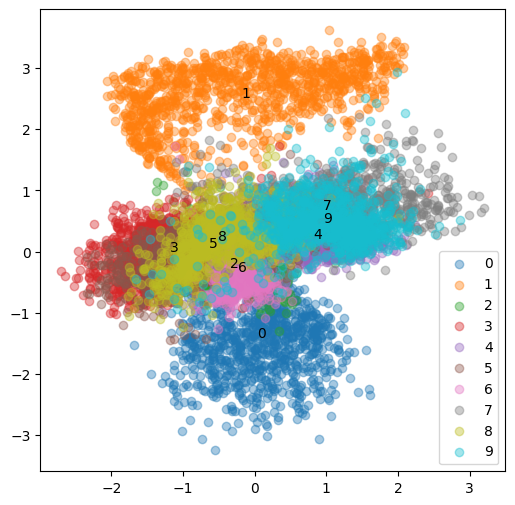

Epoch 41 Batch 233 Loss 0.5883
Epoch 42 Batch 233 Loss 0.6003
Epoch 43 Batch 233 Loss 0.5966
Epoch 44 Batch 233 Loss 0.5786
Epoch 45 Batch 233 Loss 0.5899
Epoch 46 Batch 233 Loss 0.5911
Epoch 47 Batch 233 Loss 0.5972
Epoch 48 Batch 233 Loss 0.5968
Epoch 49 Batch 233 Loss 0.5854
Epoch 50 Batch 233 Loss 0.5671
Epoch 51 Batch 233 Loss 0.5826
Epoch 52 Batch 233 Loss 0.5942
Epoch 53 Batch 233 Loss 0.5807
Epoch 54 Batch 233 Loss 0.5872
Epoch 55 Batch 233 Loss 0.5663
Epoch 56 Batch 233 Loss 0.5874
Epoch 57 Batch 233 Loss 0.5794
Epoch 58 Batch 233 Loss 0.5874
Epoch 59 Batch 233 Loss 0.5719
Epoch 60 Batch 233 Loss 0.5794


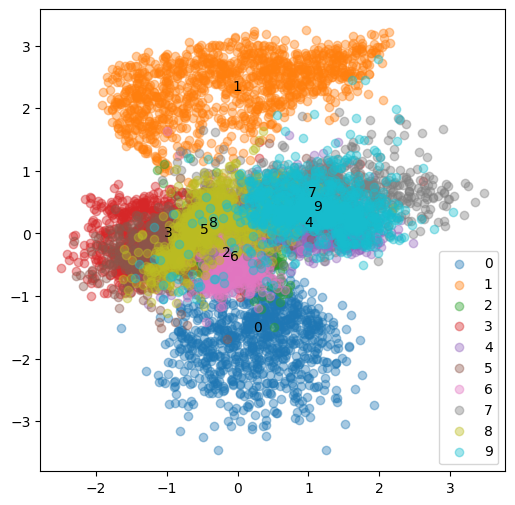

Epoch 61 Batch 233 Loss 0.5768
Epoch 62 Batch 233 Loss 0.5834
Epoch 63 Batch 233 Loss 0.5738
Epoch 64 Batch 233 Loss 0.5865
Epoch 65 Batch 233 Loss 0.5857
Epoch 66 Batch 233 Loss 0.5813
Epoch 67 Batch 233 Loss 0.5732
Epoch 68 Batch 233 Loss 0.5873
Epoch 69 Batch 233 Loss 0.5663
Epoch 70 Batch 233 Loss 0.5702
Epoch 71 Batch 233 Loss 0.5744
Epoch 72 Batch 233 Loss 0.5685
Epoch 73 Batch 233 Loss 0.5803
Epoch 74 Batch 233 Loss 0.5673
Epoch 75 Batch 233 Loss 0.5765
Epoch 76 Batch 233 Loss 0.5709
Epoch 77 Batch 233 Loss 0.5781
Epoch 78 Batch 233 Loss 0.5825
Epoch 79 Batch 233 Loss 0.5669
Epoch 80 Batch 233 Loss 0.5753


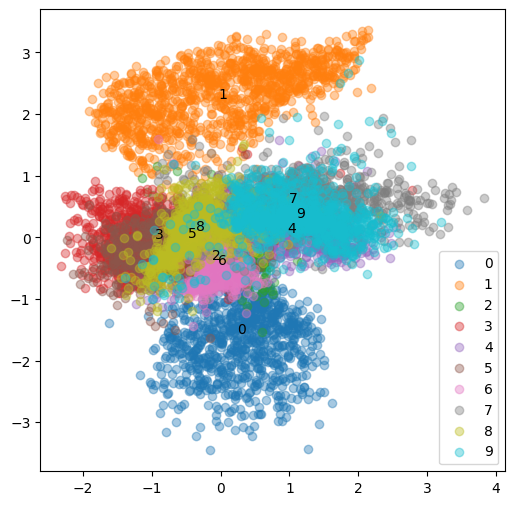

Epoch 81 Batch 233 Loss 0.5775
Epoch 82 Batch 233 Loss 0.5747
Epoch 83 Batch 233 Loss 0.5681
Epoch 84 Batch 233 Loss 0.5816
Epoch 85 Batch 233 Loss 0.5695
Epoch 86 Batch 233 Loss 0.5740
Epoch 87 Batch 233 Loss 0.5695
Epoch 88 Batch 233 Loss 0.5623
Epoch 89 Batch 233 Loss 0.5628
Epoch 90 Batch 233 Loss 0.5596
Epoch 91 Batch 233 Loss 0.5623
Epoch 92 Batch 233 Loss 0.5686
Epoch 93 Batch 233 Loss 0.5723
Epoch 94 Batch 233 Loss 0.5653
Epoch 95 Batch 233 Loss 0.5721
Epoch 96 Batch 233 Loss 0.5695
Epoch 97 Batch 233 Loss 0.5510
Epoch 98 Batch 233 Loss 0.5688
Epoch 99 Batch 233 Loss 0.5788
Epoch 100 Batch 233 Loss 0.5620


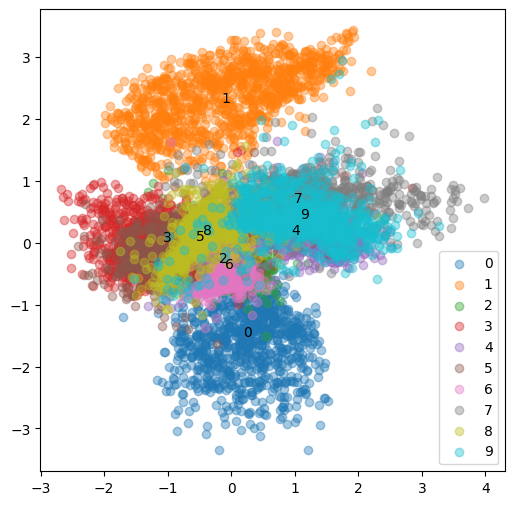

Epoch 101 Batch 233 Loss 0.5632
Epoch 102 Batch 233 Loss 0.5619
Epoch 103 Batch 233 Loss 0.5666
Epoch 104 Batch 233 Loss 0.5603
Epoch 105 Batch 233 Loss 0.5883
Epoch 106 Batch 233 Loss 0.5701
Epoch 107 Batch 233 Loss 0.5684
Epoch 108 Batch 233 Loss 0.5810
Epoch 109 Batch 233 Loss 0.5705
Epoch 110 Batch 233 Loss 0.5781
Epoch 111 Batch 233 Loss 0.5824
Epoch 112 Batch 233 Loss 0.5803
Epoch 113 Batch 233 Loss 0.5813
Epoch 114 Batch 233 Loss 0.5770
Epoch 115 Batch 233 Loss 0.5593
Epoch 116 Batch 233 Loss 0.5636
Epoch 117 Batch 233 Loss 0.5686
Epoch 118 Batch 233 Loss 0.5697
Epoch 119 Batch 233 Loss 0.5518
Epoch 120 Batch 233 Loss 0.5690


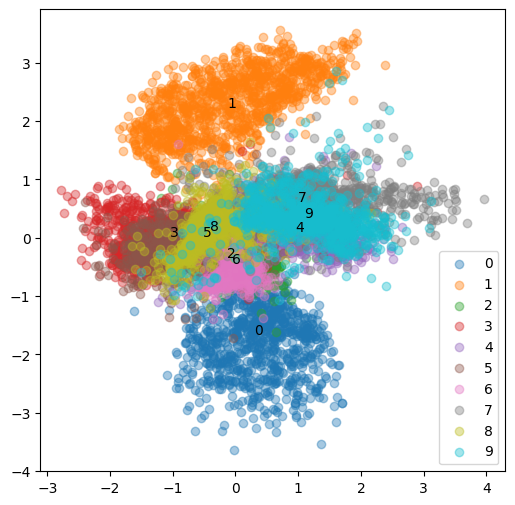

Epoch 121 Batch 233 Loss 0.5623
Epoch 122 Batch 233 Loss 0.5648
Epoch 123 Batch 233 Loss 0.5594
Epoch 124 Batch 233 Loss 0.5685
Epoch 125 Batch 233 Loss 0.5610
Epoch 126 Batch 233 Loss 0.5555
Epoch 127 Batch 233 Loss 0.5684
Epoch 128 Batch 233 Loss 0.5571
Epoch 129 Batch 233 Loss 0.5516
Epoch 130 Batch 233 Loss 0.5630
Epoch 131 Batch 233 Loss 0.5649
Epoch 132 Batch 233 Loss 0.5670
Epoch 133 Batch 233 Loss 0.5792
Epoch 134 Batch 233 Loss 0.5618
Epoch 135 Batch 233 Loss 0.5643
Epoch 136 Batch 233 Loss 0.5794
Epoch 137 Batch 233 Loss 0.5594
Epoch 138 Batch 233 Loss 0.5658
Epoch 139 Batch 233 Loss 0.5689
Epoch 140 Batch 233 Loss 0.5660


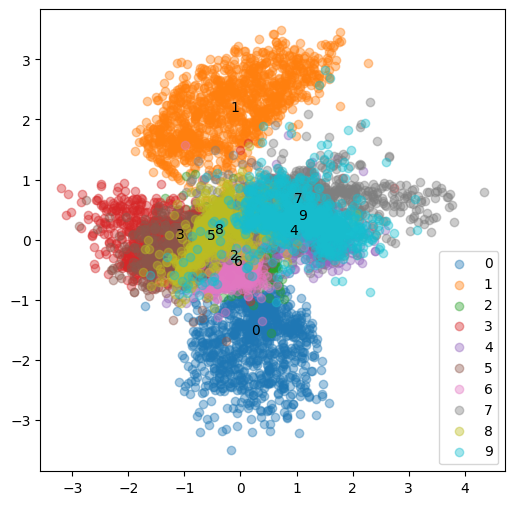

Epoch 141 Batch 233 Loss 0.5619
Epoch 142 Batch 233 Loss 0.5612
Epoch 143 Batch 233 Loss 0.5592
Epoch 144 Batch 233 Loss 0.5680
Epoch 145 Batch 233 Loss 0.5612
Epoch 146 Batch 233 Loss 0.5575
Epoch 147 Batch 233 Loss 0.5737
Epoch 148 Batch 233 Loss 0.5635
Epoch 149 Batch 233 Loss 0.5623
Epoch 150 Batch 233 Loss 0.5685
Epoch 151 Batch 233 Loss 0.5593
Epoch 152 Batch 233 Loss 0.5604
Epoch 153 Batch 233 Loss 0.5484
Epoch 154 Batch 233 Loss 0.5635
Epoch 155 Batch 233 Loss 0.5518
Epoch 156 Batch 233 Loss 0.5747
Epoch 157 Batch 233 Loss 0.5841
Epoch 158 Batch 233 Loss 0.5595
Epoch 159 Batch 233 Loss 0.5645
Epoch 160 Batch 233 Loss 0.5539


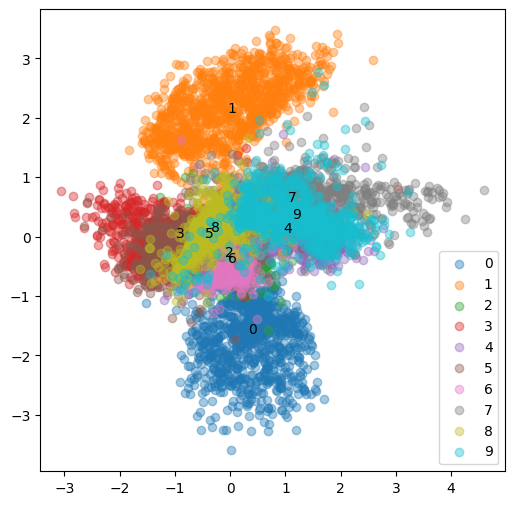

Epoch 161 Batch 233 Loss 0.5625
Epoch 162 Batch 233 Loss 0.5592
Epoch 163 Batch 233 Loss 0.5617
Epoch 164 Batch 233 Loss 0.5496
Epoch 165 Batch 233 Loss 0.5440
Epoch 166 Batch 233 Loss 0.5754
Epoch 167 Batch 233 Loss 0.5648
Epoch 168 Batch 233 Loss 0.5669
Epoch 169 Batch 233 Loss 0.5485
Epoch 170 Batch 233 Loss 0.5476
Epoch 171 Batch 233 Loss 0.5709
Epoch 172 Batch 233 Loss 0.5510
Epoch 173 Batch 233 Loss 0.5560
Epoch 174 Batch 233 Loss 0.5606
Epoch 175 Batch 233 Loss 0.5568
Epoch 176 Batch 233 Loss 0.5507
Epoch 177 Batch 233 Loss 0.5557
Epoch 178 Batch 233 Loss 0.5579
Epoch 179 Batch 233 Loss 0.5719
Epoch 180 Batch 233 Loss 0.5669


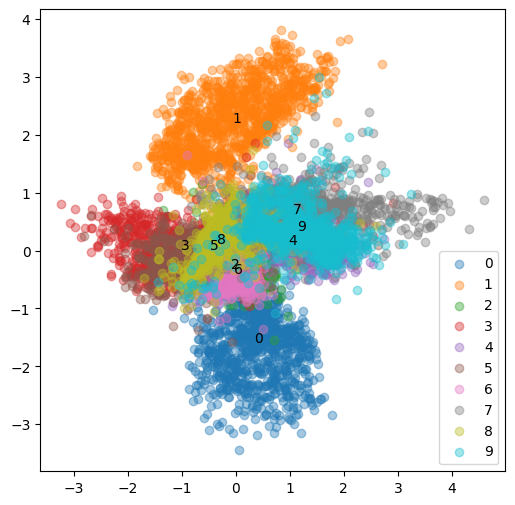

Epoch 181 Batch 233 Loss 0.5671
Epoch 182 Batch 233 Loss 0.5585
Epoch 183 Batch 233 Loss 0.5561
Epoch 184 Batch 233 Loss 0.5630
Epoch 185 Batch 233 Loss 0.5682
Epoch 186 Batch 233 Loss 0.5599
Epoch 187 Batch 233 Loss 0.5523
Epoch 188 Batch 233 Loss 0.5460
Epoch 189 Batch 233 Loss 0.5564
Epoch 190 Batch 233 Loss 0.5599
Epoch 191 Batch 233 Loss 0.5592
Epoch 192 Batch 233 Loss 0.5570
Epoch 193 Batch 233 Loss 0.5678
Epoch 194 Batch 233 Loss 0.5504
Epoch 195 Batch 233 Loss 0.5499
Epoch 196 Batch 233 Loss 0.5565
Epoch 197 Batch 233 Loss 0.5503
Epoch 198 Batch 233 Loss 0.5571
Epoch 199 Batch 233 Loss 0.5578
Epoch 200 Batch 233 Loss 0.5646


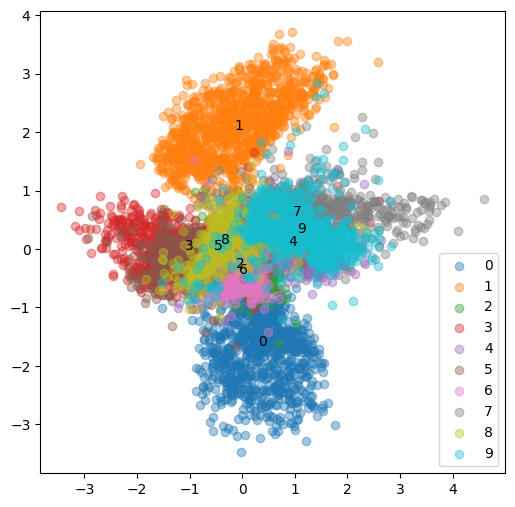

Epoch 201 Batch 233 Loss 0.5518
Epoch 202 Batch 233 Loss 0.5582
Epoch 203 Batch 233 Loss 0.5586
Epoch 204 Batch 233 Loss 0.5548
Epoch 205 Batch 233 Loss 0.5432
Epoch 206 Batch 233 Loss 0.5577
Epoch 207 Batch 233 Loss 0.5482
Epoch 208 Batch 233 Loss 0.5685
Epoch 209 Batch 233 Loss 0.5572
Epoch 210 Batch 233 Loss 0.5596
Epoch 211 Batch 233 Loss 0.5611
Epoch 212 Batch 233 Loss 0.5457
Epoch 213 Batch 233 Loss 0.5509
Epoch 214 Batch 233 Loss 0.5538
Epoch 215 Batch 233 Loss 0.5631
Epoch 216 Batch 233 Loss 0.5595
Epoch 217 Batch 233 Loss 0.5601
Epoch 218 Batch 233 Loss 0.5449
Epoch 219 Batch 233 Loss 0.5625
Epoch 220 Batch 233 Loss 0.5593


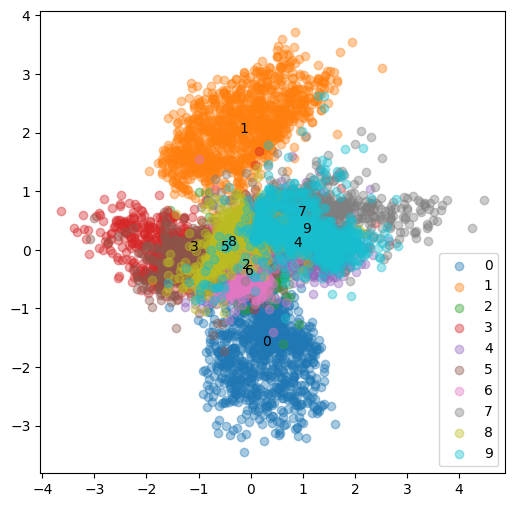

Epoch 221 Batch 233 Loss 0.5591
Epoch 222 Batch 233 Loss 0.5505
Epoch 223 Batch 233 Loss 0.5646
Epoch 224 Batch 233 Loss 0.5602
Epoch 225 Batch 233 Loss 0.5617
Epoch 226 Batch 233 Loss 0.5770
Epoch 227 Batch 233 Loss 0.5543
Epoch 228 Batch 233 Loss 0.5620
Epoch 229 Batch 233 Loss 0.5367
Epoch 230 Batch 233 Loss 0.5490
Epoch 231 Batch 233 Loss 0.5478
Epoch 232 Batch 233 Loss 0.5514
Epoch 233 Batch 233 Loss 0.5574
Epoch 234 Batch 233 Loss 0.5495
Epoch 235 Batch 233 Loss 0.5611
Epoch 236 Batch 233 Loss 0.5455
Epoch 237 Batch 233 Loss 0.5445
Epoch 238 Batch 233 Loss 0.5488
Epoch 239 Batch 233 Loss 0.5543
Epoch 240 Batch 233 Loss 0.5479


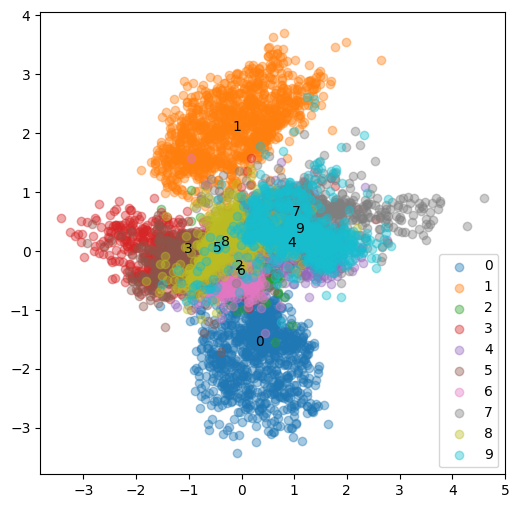

Epoch 241 Batch 233 Loss 0.5524
Epoch 242 Batch 233 Loss 0.5522
Epoch 243 Batch 233 Loss 0.5602
Epoch 244 Batch 233 Loss 0.5624
Epoch 245 Batch 233 Loss 0.5461
Epoch 246 Batch 233 Loss 0.5569
Epoch 247 Batch 233 Loss 0.5591
Epoch 248 Batch 233 Loss 0.5652
Epoch 249 Batch 233 Loss 0.5637
Epoch 250 Batch 233 Loss 0.5428
Epoch 251 Batch 233 Loss 0.5466
Epoch 252 Batch 233 Loss 0.5477
Epoch 253 Batch 233 Loss 0.5580
Epoch 254 Batch 233 Loss 0.5540
Epoch 255 Batch 233 Loss 0.5485
Epoch 256 Batch 233 Loss 0.5450
Epoch 257 Batch 233 Loss 0.5476
Epoch 258 Batch 233 Loss 0.5585
Epoch 259 Batch 233 Loss 0.5417
Epoch 260 Batch 233 Loss 0.5483


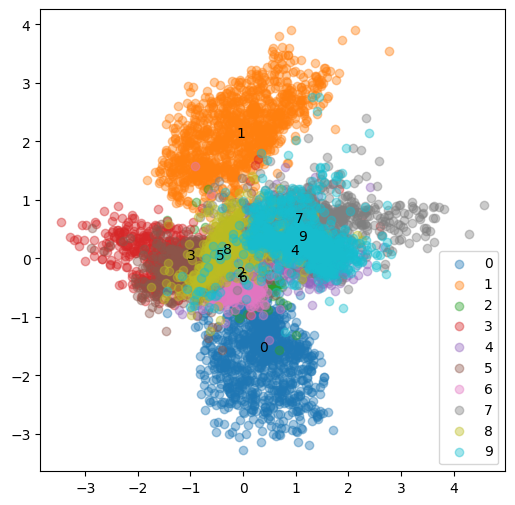

Epoch 261 Batch 233 Loss 0.5513
Epoch 262 Batch 233 Loss 0.5482
Epoch 263 Batch 233 Loss 0.5664
Epoch 264 Batch 233 Loss 0.5491
Epoch 265 Batch 233 Loss 0.5423
Epoch 266 Batch 233 Loss 0.5543
Epoch 267 Batch 233 Loss 0.5553
Epoch 268 Batch 233 Loss 0.5466
Epoch 269 Batch 233 Loss 0.5572
Epoch 270 Batch 233 Loss 0.5554
Epoch 271 Batch 233 Loss 0.5545
Epoch 272 Batch 233 Loss 0.5432
Epoch 273 Batch 233 Loss 0.5482
Epoch 274 Batch 233 Loss 0.5436
Epoch 275 Batch 233 Loss 0.5631
Epoch 276 Batch 233 Loss 0.5468
Epoch 277 Batch 233 Loss 0.5584
Epoch 278 Batch 233 Loss 0.5599
Epoch 279 Batch 233 Loss 0.5639
Epoch 280 Batch 233 Loss 0.5560


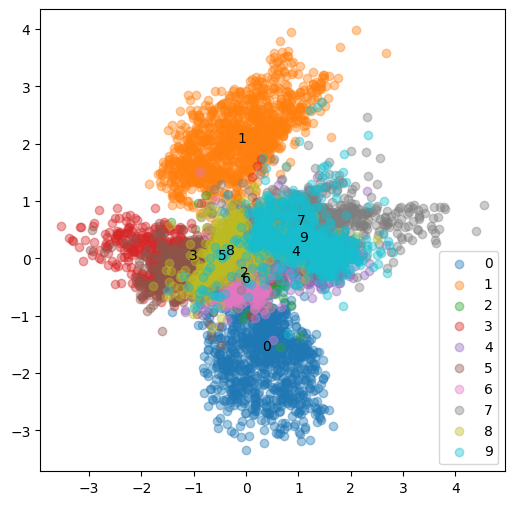

Epoch 281 Batch 233 Loss 0.5509
Epoch 282 Batch 233 Loss 0.5531
Epoch 283 Batch 233 Loss 0.5465
Epoch 284 Batch 233 Loss 0.5654
Epoch 285 Batch 233 Loss 0.5621
Epoch 286 Batch 233 Loss 0.5537
Epoch 287 Batch 233 Loss 0.5579
Epoch 288 Batch 233 Loss 0.5611
Epoch 289 Batch 233 Loss 0.5272
Epoch 290 Batch 233 Loss 0.5571
Epoch 291 Batch 233 Loss 0.5557
Epoch 292 Batch 233 Loss 0.5416
Epoch 293 Batch 233 Loss 0.5563
Epoch 294 Batch 233 Loss 0.5575
Epoch 295 Batch 233 Loss 0.5581
Epoch 296 Batch 233 Loss 0.5509
Epoch 297 Batch 233 Loss 0.5553
Epoch 298 Batch 233 Loss 0.5336
Epoch 299 Batch 233 Loss 0.5519
Epoch 300 Batch 233 Loss 0.5581


In [34]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

BUFFER_SIZE = 256
BATCH_SIZE = 256
dataset = tf.data.Dataset.from_tensor_slices((x_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
steps_per_epoch = len(x_train) // BATCH_SIZE # 何個に分けるか


EPOCHS = 300
vae = VAE(input_dim=x_train.shape[-1], hidden_dim=64, latent_dim=2)
for epoch in range(EPOCHS):
    if epoch % 20 == 0:
        mu, sigma, z = vae.encode(x_test) # 0番目：平均, 1番目: log標準偏差, 2番目: 潜在変数
        z = z.numpy()
        plt.figure(figsize=(6, 6))
        for i in range(10):
            index = y_test == i
            plt.scatter(z[index, 0], z[index, 1], label=str(i), alpha=0.4)
            z1_mean = z[index, 0].mean()
            z2_mean = z[index, 1].mean()
            plt.annotate(str(i), (z1_mean, z2_mean))
    
        plt.legend()
        plt.show()
    for batch, x in enumerate(dataset):
        batch_loss = train_step(x)
    #if batch % 100 == 0:
    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))



In [22]:
# class _VAE(keras.Model):
#     def __init__(self):
#         super().__init__()

#         self.z_size = 32  # 潜在空間のサイズ

#         # --- encoder
#         input_shape = (64, 64, 3)
#         in_layer = c = kl.Input(shape=input_shape)
#         c = kl.Conv2D(filters=32, kernel_size=4, strides=2, activation="relu")(c)
#         c = kl.Conv2D(filters=64, kernel_size=4, strides=2, activation="relu")(c)
#         c = kl.Conv2D(filters=128, kernel_size=4, strides=2, activation="relu")(c)
#         c = kl.Conv2D(filters=256, kernel_size=4, strides=2, activation="relu")(c)
#         c = kl.Flatten()(c)
#         z_mean = kl.Dense(self.z_size)(c)
#         z_log_var = kl.Dense(self.z_size)(c)
#         self.encoder = keras.Model(in_layer, [z_mean, z_log_var])

#         # --- decoder
#         in_state = c = kl.Input(shape=(self.z_size,))
#         c = kl.Dense(2 * 2 * 256, activation="relu")(c)
#         c = kl.Reshape((1, 1, 2 * 2 * 256))(c)
#         c = kl.Conv2DTranspose(128, kernel_size=5, strides=2, padding="valid", activation="relu")(c)
#         c = kl.Conv2DTranspose(64, kernel_size=5, strides=2, padding="valid", activation="relu")(c)
#         c = kl.Conv2DTranspose(32, kernel_size=6, strides=2, padding="valid", activation="relu")(c)
#         c = kl.Conv2DTranspose(3, kernel_size=6, strides=2, padding="valid", activation="sigmoid")(c)
#         self.decoder = keras.Model(in_state, c)

#     def call(self, x):
#         return self.decode(self.encode(x))

#     def encode(self, x, training=False):
#         z_mean, z_log_var = self.encoder(x, training=training)

#         # reparameterize
#         e = tf.random.normal(z_mean.shape)
#         z = z_mean + tf.exp(0.5 * z_log_var) * e

#         if training:
#             return z_mean, z_log_var, z
#         else:
#             return z

#     def decode(self, z, training=False):
#         return self.decoder(z, training=training)

#     def sample(self, size=1):
#         z = np.random.normal(size=(size, self.z_size))
#         return self.decode(z), z

ラベル:  2


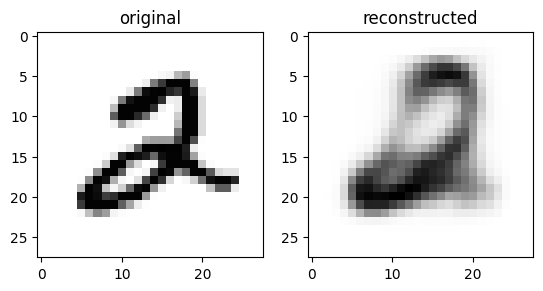

In [35]:
i = 5
mu, log_sigma, reconstructed, z = vae(x_train[i].reshape(1, -1))# * 255
print('ラベル: ', y_train[i])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_train[i].reshape(28, 28) * 255, cmap='Greys');
ax[0].set_title('original')
ax[1].imshow(reconstructed.numpy().reshape(28, 28) * 255, cmap='Greys');
ax[1].set_title('reconstructed')
plt.show()

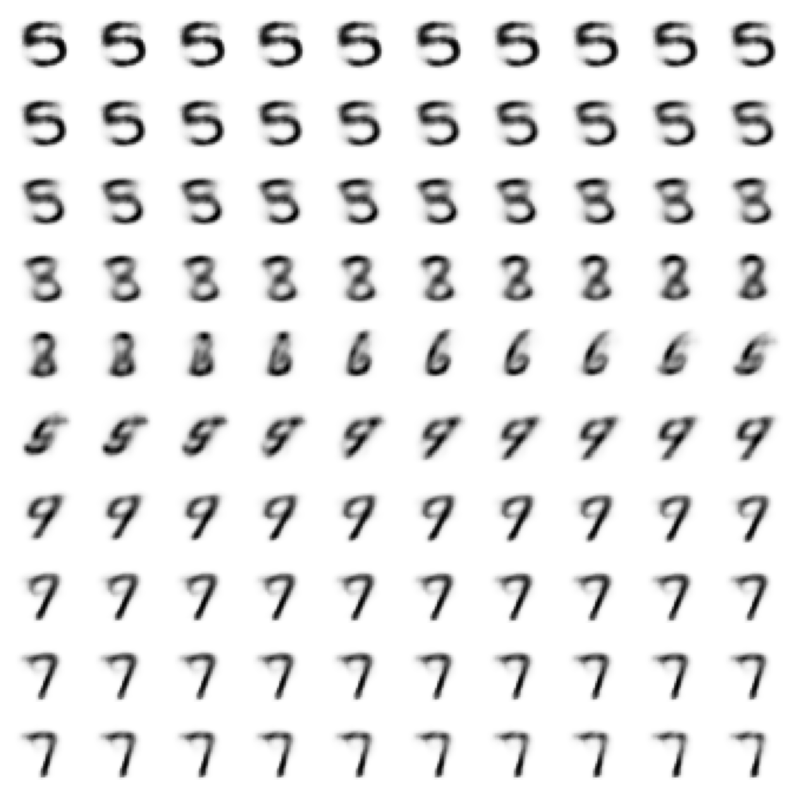

In [36]:
z1 = np.linspace(-2, 2, 100)
z2 = np.linspace(-1, 1, 100)
 
num_of_rows = 10
fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
for i, (z1_, z2_) in enumerate(zip(z1, z2)):
  sampled = vae.decode(np.array([z1_, z2_]).reshape(1, 2))
  ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
  ax[divmod(i, num_of_rows)].set_axis_off()
plt.show()


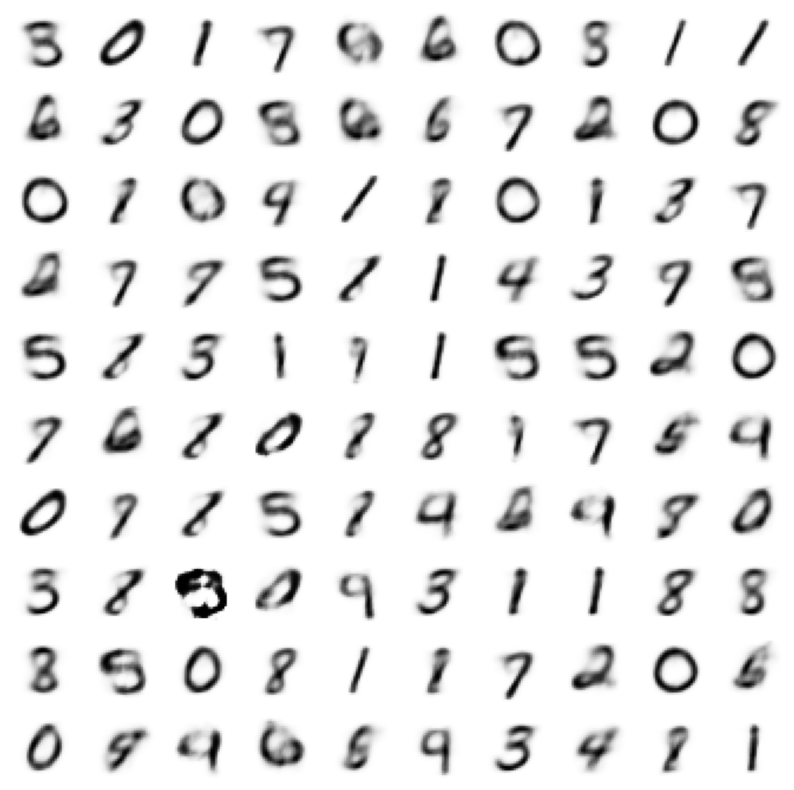

In [37]:
num_of_rows = 10
fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
for i in range(100):
  sampled = vae.decode(np.random.normal(0, 1, size=2).reshape(1, 2))
  ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
  ax[divmod(i, num_of_rows)].set_axis_off()
plt.show()